In [22]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from numba import jit, njit
from scipy.stats import  t

In [3]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    # Wiener Process by default
    # use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    @staticmethod
    @njit
    def EulerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        xs = x0 + bxt(x0, t0, params) * (t - t0)
        sigma2 = sigmaxt(x0, t0, params)**2 * (t - t0)

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def OzakiDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        K = 1 / (t - t0) * np.log(1 + bxt(x0, t0, params) / (x0 * bxt_x(x0, t0, params)) * (np.exp(bxt_x(x0, t0, params) * (t - t0)) - 1))
        E = x0 + bxt(x0, t0, params) / bxt_x(x0, t0, params) * (np.exp(bxt_x(x0, t0, params) * (t - t0)) - 1)
        V = sigmaxt(x0, t0, params)**2 / (2 * K) * (np.exp(2 * K * (t - t0)) - 1)

        xs = E
        sigma2 = V

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def ShojiOzakiDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        L = bxt_x(x0, t0, params)

        #safe division
        if L == 0:
            L = L + 0.001

        M = sigmaxt(x0, t0, params)**2 / 2 * bxt_xx(x0, t0, params) + bxt_t(x0, t0, params)

        A = 1 + bxt(x0, t0, params) / (x0 * L) * (np.exp(L * (t - t0)) - 1) + M / (x0 * L**2) * \
            (np.exp(L * (t - t0)) - 1 - L * (t - t0))
        B = sigmaxt(x0, t0, params)**2 * 1/(2 * L) * (np.exp(2 * L * (t - t0)) - 1)

        xs = A * x0
        sigma2 = B

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def KesslerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        E = x0 + bxt(x0, t0, params) * (t - t0) + (bxt(x0, t0, params) * bxt_x(x0, t0, params) + 1/2 * \
            sigmaxt(x0, t0, params)**2 * bxt_xx(x0, t0, params)) * 1/2 * (t - t0)**2
        V = x0**2 + (2 * bxt(x0, t0, params) * x0 + sigmaxt(x0, t0, params)**2 ) * (t - t0)\
            + (2 * bxt(x0, t0, params) * (bxt_x(x0, t0, params) * x0 + bxt(x0, t0, params) + \
                sigmaxt(x0, t0, params) * sigmaxt_x(x0, t0, params))\
            + sigmaxt(x0, t0, params)**2 * (bxt_xx(x0, t0, params) * x0 + 2 * bxt_x(x0, t0, params) +\
                sigmaxt_x(x0, t0, params)**2 + sigmaxt(x0, t0, params) * sigmaxt_xx(x0, t0, params))) * (t - t0)**2 / 2 - E**2

        xs = E

        #safe division
        if V == 0:
            V = V + 0.001

        sigma2 = V

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def MLogLik(params, t_data, x_data, density, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        Nt = len(x_data)
        Nx = len(x_data[0])
        log_data = np.zeros(Nx)
        for k in range(0, Nx):
            m_log_lik = 0
            for j in range(1, Nt):
                m_log_lik += density(x_data[j][k], t_data[j], x_data[j - 1][k], t_data[j - 1], params,
                                     bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t)
            log_data[k] = m_log_lik

        res = -np.mean(log_data)
        return res

    def EulerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.EulerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def OzakiEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.OzakiDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def ShojiOzakiEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.ShojiOzakiDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def KesslerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.KesslerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta, mu, sigma]

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * (params[1] - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x**(params[3] - 2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

class Task5process(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * t * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[1] * x

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[0] * t

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return params[0] * x

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

class HullWhiteprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * t * (params[1] * np.sqrt(t) - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * t

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0] * t

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return params[0] * params[1] * 3/2 * np.sqrt(t)

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

NameError: name 'njit' is not defined

Task 1. Evaluate the conditional density of the Ornstein-Uhlenbeck process
$$dX_t = (3-X_t)dt+2dW_t, \quad X_0=1, \quad %\theta=(1, 3, 2), \quad
N=100000,
\quad \Delta=1$$ and calculate the
maximum likelihood estimation.  

In [24]:
Nx = 100000
Nt = 300

T = 1

params_OU = np.array([3, 1, 2])

x0 = 1
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [25]:
OUp.EulerEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -221.88647317667946
        x: [ 3.011e+00  9.977e-01  2.000e+00]
      nit: 17
      jac: [-9.095e-05  1.131e-03  1.154e-03]
     nfev: 76
     njev: 19
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [11]:
OUp.ShojiOzakiEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -221.95906136888541
        x: [ 3.024e+00  1.002e+00  2.010e+00]
      nit: 15
      jac: [-1.421e-04  3.013e-04  7.219e-04]
     nfev: 68
     njev: 17
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [21]:
OUp.KesslerEstimation(t_data, x_data_OU)

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [ 1.000e+00  1.000e+00  1.000e+00]
      nit: 0
      jac: [       nan        nan        nan]
     nfev: 84
     njev: 21
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Task. Find the maximum likelihood estimators  numerically
 for Ornstein-Uhlenbeck process
 $$
 dX_t = -\theta_2X_tdt + \theta_3dW_t, \quad \theta=(0, 3, 2), \quad
N=1000, \quad \Delta=1
$$
and compare with explicit estimations

$$
\hat{\theta}_{2,n} = -\frac{1}{\Delta}\log \left(\frac{\sum_{i=1}^n X_{i-1}X_i} {\sum_{i=1}^n X^2_{i-1}}\right),
$$
$$
\hat{\theta}_{3,n} = \sqrt{\frac{2\hat{\theta}_{2,n}}
{n(1 - e^{-2\Delta  \hat{\theta}_{2,n}})}
\sum_{i=1}^n (X_i- X_{i-1} e^{-\Delta \hat{\theta}_{2, n}})^2}.
$$

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

# параметры для процесса Орнштейна-Уленбека
theta_true = (0, 3, 2)  # истинные значения параметров theta_0, theta_2, theta_3
theta_2_true, theta_3_true = theta_true[1], theta_true[2]  # извлекаем значения theta_2 и theta_3
N = 1000  # количество наблюдений
delta = 1  # временной шаг

# шаг 1: генерируем траекторию процесса орнштейна-уленбека
np.random.seed(42)
X = np.zeros(N)  # создаем массив для хранения значений процесса
for i in range(1, N):
    # вычисляем значение процесса на следующем шаге на основе предыдущего значения
    # используя формулу для процесса орнштейна-уленбека
    X[i] = (X[i-1] * np.exp(-theta_2_true * delta) + 
            theta_3_true * np.sqrt((1 - np.exp(-2 * theta_2_true * delta)) / (2 * theta_2_true)) 
            * np.random.normal())

# шаг 2: определяем функцию логарифмического правдоподобия
def log_likelihood(params, X, delta):
    theta_2, theta_3 = params  # извлекаем параметры из списка params
    n = len(X) - 1  # количество наблюдений минус один
    ll = 0  # начальное значение логарифма правдоподобия
    for i in range(1, len(X)):
        # среднее значение для условного распределения X[i] при заданном X[i-1]
        mean = X[i-1] * np.exp(-theta_2 * delta)
        # дисперсия для условного распределения X[i] при заданном X[i-1]
        var = theta_3**2 * (1 - np.exp(-2 * theta_2 * delta)) / (2 * theta_2)
        # добавляем логарифм плотности вероятности нормального распределения к ll
        ll += norm.logpdf(X[i], mean, np.sqrt(var))
    return -ll  # возвращаем отрицательное значение для минимизации

# начальные предположения для theta_2 и theta_3
initial_guess = [1.0, 1.0]

# находим оценки методом максимального правдоподобия путем минимизации отрицательного логарифма правдоподобия
result = minimize(log_likelihood, initial_guess, args=(X, delta), bounds=[(0.01, 10), (0.01, 10)])
theta_2_mle, theta_3_mle = result.x  # извлекаем найденные значения theta_2 и theta_3

# шаг 3: вычисляем явные оценки для theta_2 и theta_3 по заданным формулам
# сумма произведений соседних значений X[i-1] * X[i]
sum_Xi_Xim1 = np.sum(X[:-1] * X[1:])
# сумма квадратов предыдущих значений X[i-1]^2
sum_Xim1_sq = np.sum(X[:-1]**2)

# явная оценка для theta_2
theta_2_explicit = -1 / delta * np.log(sum_Xi_Xim1 / sum_Xim1_sq)

# явная оценка для theta_3
theta_3_explicit = np.sqrt((2 * theta_2_explicit / (N * (1 - np.exp(-2 * delta * theta_2_explicit)))) * 
                           np.sum((X[1:] - X[:-1] * np.exp(-delta * theta_2_explicit))**2))

# шаг 4: выводим результаты и сравниваем оценки
print("оценки, найденные численно методом максимального правдоподобия:")
print(f"theta_2 (м.в.о.) = {theta_2_mle}")
print(f"theta_3 (м.в.о.) = {theta_3_mle}")

print("\nявные оценки:")
print(f"theta_2 (явная) = {theta_2_explicit}")
print(f"theta_3 (явная) = {theta_3_explicit}")

оценки, найденные численно методом максимального правдоподобия:
theta_2 (м.в.о.) = 3.1455860432124494
theta_3 (м.в.о.) = 2.0047684295588057

явные оценки:
theta_2 (явная) = 3.1453822530466207
theta_3 (явная) = 2.003695539169668


Task 3. Consider  the Chan-Karolyi-Longstaff-Sanders (CKLS) model
$$
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
$$
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

Use the Euler method and
* generate the sample data $X_{t_i}$ with time step $\Delta t =10^{-4}$,  
* estimate drift and diffusion coefficients,
* compute confidence intervals for all parameters in a fitted SDE.  


In [26]:
Nx = 1
Nt = 10000

T = 1

params_CKLS = np.array([1, 2, 0.5, 0.3])

x0 = 2
init_state = x0 * np.ones(Nx)

CKLSp = CKLSprocess(params_CKLS, T, Nx, Nt, init_state)

t_data, x_data_CKLS = CKLSp.EulerSolution()

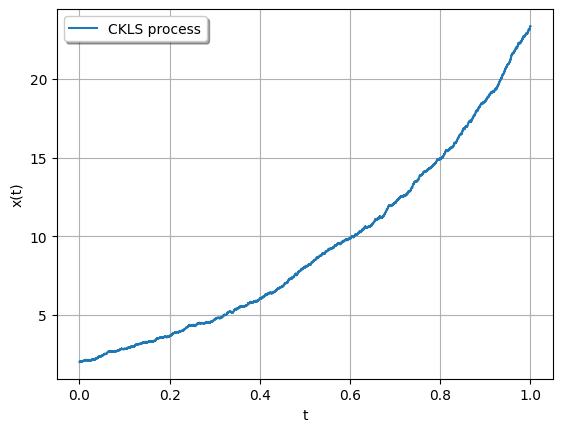

In [27]:
plt.plot(t_data, x_data_CKLS[:,0], label = 'CKLS process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [28]:
CKLSp.EulerEstimation(t_data, x_data_CKLS)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -32700.192219496745
        x: [ 1.114e+00  2.153e+00  5.008e-01  3.018e-01]
      nit: 18
      jac: [-6.807e-01  7.603e-02  3.274e-02  6.548e-03]
     nfev: 115
     njev: 23
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [29]:
#Confidence intervals
n = 50
result = np.zeros((n, 4))
for k in range(0, n):
    t_data, x_data_CKLS = CKLSp.EulerSolution()
    result[k] = CKLSp.EulerEstimation(t_data, x_data_CKLS).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 4):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 1.2625653616384256 +- 0.25569583901177956 with 95.0% prob
theta1 = 1.9503896652124493 +- 0.04734224859958106 with 95.0% prob
theta2 = 0.5005690519871657 +- 0.003016716073563418 with 95.0% prob
theta3 = 0.29928034023086575 +- 0.003344747241718138 with 95.0% prob


Task 4. Consider the Vasicek model
$$
dX_{t} = \theta_{1} (\theta_{2}- X_{t}) dt + \theta_{3} dW_{t},\qquad X_{0}=5
$$
with $\theta_{1}=3$, $\theta_{2}=2$ and $\theta_{3}=0.5$.

Use the Ozaki method and
*   generate the sample data $X_{t_i}$, time step $\Delta t =10^{-2}$,
*   estimate drift and diffusion coefficients,
*   compute confidence intervals for all parameters in a fitted SDE.

In [30]:
Nx = 1
Nt = 100

T = 1

params_OU = np.array([3, 2, 0.5])

x0 = 5
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [31]:
OUp.OzakiEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -179.66388018223276
        x: [ 3.185e+00  1.954e+00  4.031e-01]
      nit: 16
      jac: [-1.705e-04  1.125e-03  5.295e-03]
     nfev: 96
     njev: 24
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [32]:
#Confidence intervals
n = 50
result = np.zeros((n, 3))
for k in range(0, n):
    t_data, x_data_OU = OUp.EulerSolution()
    result[k] = OUp.OzakiEstimation(t_data, x_data_OU).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 3):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 3.163666567078779 +- 0.20347758065440089 with 95.0% prob
theta1 = 1.9685091178938736 +- 0.0887815424436207 with 95.0% prob
theta2 = 0.38932747073612534 +- 0.09393507492585448 with 95.0% prob


Task 5. Consider the model
$$
  dX_{t} = a(t)X_{t} dt + \theta_{2}X_{t} dW_{t},\qquad X_{0}=10
$$
with $a(t) = \theta_{1}t$, $\theta_{1}=-2$, $\theta_{2}=0.2$.

Use the Shoji-Ozaki method and:
* generate the sample data $X_{t_i}$ time step $\Delta t =10^{-3}$,  
* estimate drift and diffusion coefficients,
* compute confidence intervals for all parameters in a fitted SDE.

In [33]:
Nx = 1
Nt = 1000

T = 1

params_T5 = np.array([-2, 0.2])

x0 = 5
init_state = x0 * np.ones(Nx)

T5p = Task5process(params_T5, T, Nx, Nt, init_state)

t_data, x_data_T5 = T5p.EulerSolution()

In [34]:
T5p.ShojiOzakiEstimation(t_data, x_data_T5)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -2521.295013993064
        x: [-2.104e+00  1.967e-01]
      nit: 15
      jac: [ 2.979e-02  3.397e-02]
     nfev: 144
     njev: 48
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

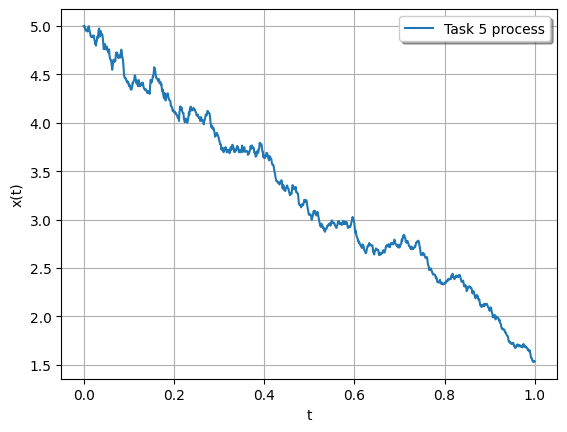

In [35]:
plt.plot(t_data, x_data_T5[:,0], label = 'Task 5 process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [36]:
#Confidence intervals
n = 50
result = np.zeros((n, 2))
for k in range(0, n):
    t_data, x_data_T5 = T5p.EulerSolution()
    result[k] = T5p.ShojiOzakiEstimation(t_data, x_data_T5).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 2):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = -1.9268326023994566 +- 0.0917545821545623 with 95.0% prob
theta1 = 0.17638110993957531 +- 0.02701304914215358 with 95.0% prob


Task 6. Consider the Hull-White (extended Vasicek) model
$$
  dX_{t} = a(t)(b(t)-X_{t}) dt + \sigma(t) dW_{t},\qquad X_{0}=2
$$
with $a(t) = \theta_{1}t$, $b(t)=\theta_{2}\sqrt{t}$, the volatility depends on time $\sigma(t)=\theta_{3}t$.

Generate sample data of $X_t$ with time step $\Delta t =10^{-3}$ and $\theta_{1}=3$, $\theta_{2}=1$ and $\theta_{3}=0.3$, then
use the Kessler method and:
*   estimate drift and diffusion coefficients,
*   compute confidence intervals for all parameters in a fitted SDE.

In [37]:
Nx = 1
Nt = 100

T = 1

params_HW = np.array([3, 1, 0.3])

x0 = 2
init_state = x0 * np.ones(Nx)

HWp = HullWhiteprocess(params_HW, T, Nx, Nt, init_state)

t_data, x_data_HW = HWp.EulerSolution()

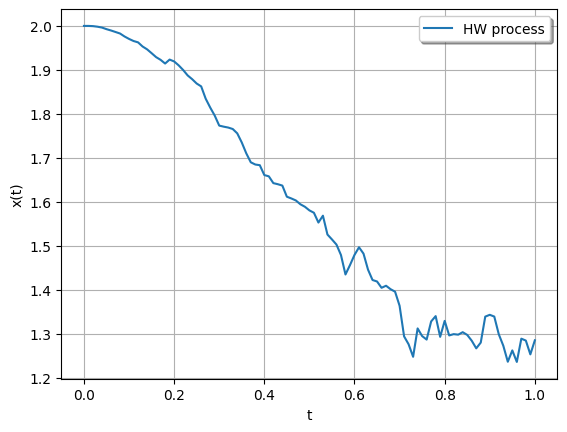

In [38]:
plt.plot(t_data, x_data_HW[:,0], label = 'HW process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [39]:
HWp.KesslerEstimation(t_data, x_data_HW)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -299.83971460625975
        x: [ 3.548e+00  1.303e+00  3.211e-01]
      nit: 16
      jac: [-1.014e-01  1.344e-01 -1.178e-01]
     nfev: 132
     njev: 33
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Task. Take a process from previous tasks and approximation method, find the solution, compute confidence intervals, and compare results with baseline.

Plot the graph and table.

Задания по вариантам
1. Байков Илья Павлович OU + Kessler
1. Гонгапшев Астемир Султанович CKLS + Shoji-Ozaki
1. Кудинкина Екатерина Андреевна CKLS + Kessler
1. Кулига Андрей Владимирович Vasicek + Euler
1. Мартыненко Александр Станиславович Vasicek + Shoji-Ozaki
1. Мироманов Даниил Борисович Vasicek + Kessler
1. Паршаков Никита Сергеевич extended Vasicek + Euler
1. Петренко Влада Витальевна extended Vasicek + Ozaki
1. Тумачев Серафим Дмитриевич extended Vasicek + Shoji-Ozaki
1. Хубиев Касымхан Юсуфович model 5 + Euler
1. Ширяева Софья Игоревна model 5 + Ozaki
1. Якунин Сергей Александрович model 5 + Kessler
1. Трофимов Яков Георгиевич CKLS + Ozaki


True Parameters: [0.5, 0.3]
Estimated Parameters: [0.52683278 0.32880062]


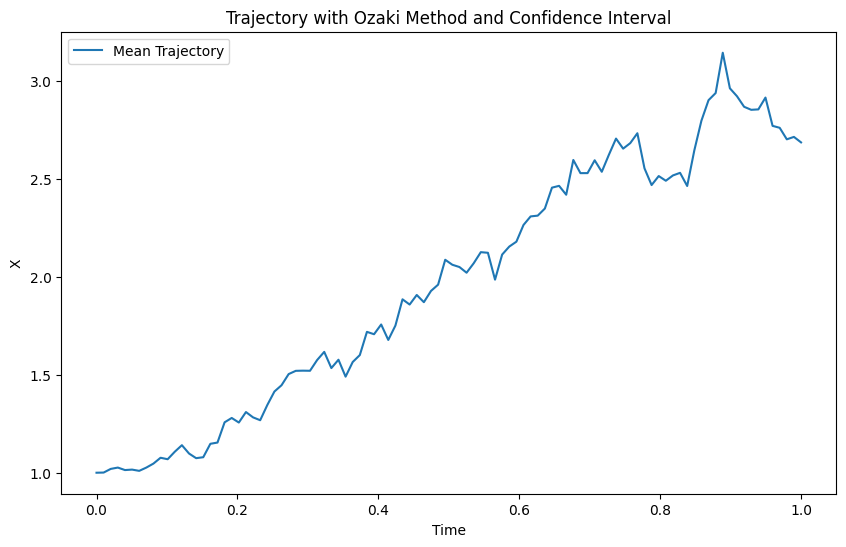

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class Model5ProcessOzaki:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state if init_state is not None else np.ones(Nx)

    def drift(self, x):
        theta1 = self.params[0]
        return theta1 * x

    def diffusion(self, x):
        theta2 = self.params[1]
        return theta2 * x

    def generate_trajectory(self):
        X = np.zeros((self.Nt, self.Nx))
        X[0, :] = self.init_state
        dt = self.T / self.Nt
        for i in range(1, self.Nt):
            x_current = X[i - 1, :]
            b_xt = self.drift(x_current)
            bx_xt = self.params[0]
            K_x = (1 / dt) * np.log(1 + (b_xt / x_current) * ((np.exp(bx_xt * dt) - 1) / bx_xt))
            mean = x_current * np.exp(K_x * dt) + (b_xt / bx_xt) * (np.exp(bx_xt * dt) - 1)
            variance = (self.diffusion(x_current) ** 2) * (np.exp(2 * K_x * dt) - 1) / (2 * K_x)
            X[i, :] = mean + np.sqrt(variance) * np.random.normal(size=self.Nx)
        return np.linspace(0, self.T, self.Nt), X

    def ozaki_density(self, x_next, x_current, dt):
        b_xt = self.drift(x_current)
        bx_xt = self.params[0]
        K_x = (1 / dt) * np.log(1 + (b_xt / x_current) * ((np.exp(bx_xt * dt) - 1) / bx_xt))
        mean = x_current * np.exp(K_x * dt) + (b_xt / bx_xt) * (np.exp(bx_xt * dt) - 1)
        variance = (self.diffusion(x_current) ** 2) * (np.exp(2 * K_x * dt) - 1) / (2 * K_x)
        return -0.5 * np.log(2 * np.pi * variance) - (x_next - mean) ** 2 / (2 * variance)

    def mlog_likelihood(self, params, t_data, x_data):
        self.params = params
        dt = self.T / self.Nt
        log_likelihood = 0
        for i in range(1, len(t_data)):
            log_likelihood += self.ozaki_density(x_data[i], x_data[i - 1], dt)
        return -log_likelihood

    def ozaki_estimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        result = minimize(
            self.mlog_likelihood,
            x0=x0,
            args=(t_data, x_data),
            method='L-BFGS-B',
            options={'ftol': 1e-8, 'eps': 1e-8}
        )
        return result.x

def run_ozaki_estimation():
    true_params = [0.5, 0.3]
    T = 1.0
    Nx = 1
    Nt = 100
    process = Model5ProcessOzaki(params=true_params, T=T, Nx=Nx, Nt=Nt)
    
    t_data, x_data = process.generate_trajectory()
    estimated_params = process.ozaki_estimation(t_data, x_data[:, 0])

    # Print initial and estimated parameters
    print("True Parameters:", true_params)
    print("Estimated Parameters:", estimated_params)

    # Plot the trajectory and 95% confidence interval
    plt.figure(figsize=(10, 6))
    plt.plot(t_data, x_data.mean(axis=1), label="Mean Trajectory")
    plt.fill_between(
        t_data,
        x_data.mean(axis=1) - 1.96 * x_data.std(axis=1),
        x_data.mean(axis=1) + 1.96 * x_data.std(axis=1),
    )
    plt.xlabel("Time")
    plt.ylabel("X")
    plt.title("Trajectory with Ozaki Method and Confidence Interval")
    plt.legend()
    plt.show()

run_ozaki_estimation()